# 0. Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
print(f"PyTorch version: {torch.__version__}")
print(f"MPS built: {torch.backends.mps.is_built()}")
print(f"MPS available: {torch.backends.mps.is_available()}")
device = torch.device("mps")
print(f"Device used: {device}")

PyTorch version: 1.13.1
MPS built: True
MPS available: True
Device used: mps


# 1. Multilayer perceptron

In [4]:
np.random.seed(1)
torch.manual_seed(1)

## 1.a Load MNIST data set

In [5]:
mnist_train = datasets.MNIST(root = './data', train = True, download = True, transform = None)

In [6]:
mnist_test = datasets.MNIST(root = './data', train = False, download = True, transform = None)

In [7]:
print(mnist_train.data.shape)
print(mnist_test.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


Rescale data to [0,1]

In [8]:
x_train = np.array(mnist_train.data / 256.)
print(x_train.shape)
y_train = np.array(mnist_train.targets)
print(y_train.shape)
x_test = np.array(mnist_test.data / 256.)
print(x_test.shape)
y_test = np.array(mnist_test.targets)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Visualization

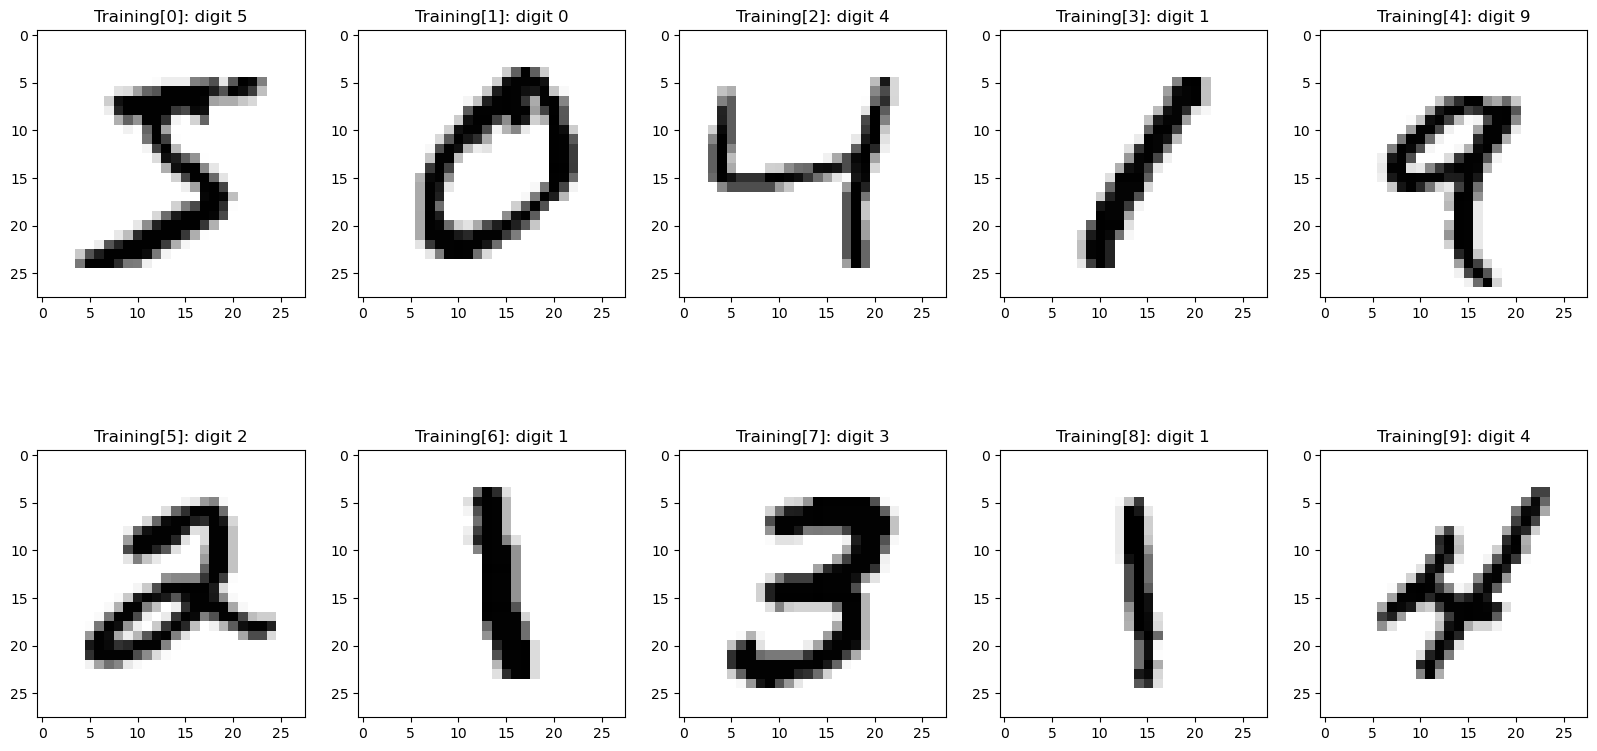

In [9]:
plt.figure(1, figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i,:,:], cmap=plt.cm.gray_r)
    plt.title('Training[' + str(i) + ']: digit ' + str(y_train[i]))

## 1.b Construct first training/test data set for '0' and '1'

Training data

In [10]:
x_train1 = np.empty((200, x_train.shape[1], x_train.shape[2]))
x_train1[:100,:,:] = x_train[y_train == 0,:,:][:100,:,:]
x_train1[100:,:,:] = x_train[y_train == 1,:,:][:100,:,:]
print(x_train1.shape)
y_train1 = np.empty((200))
y_train1[:100] = y_train[y_train == 0][:100]
y_train1[100:] = y_train[y_train == 1][:100]
print(y_train1.shape)

(200, 28, 28)
(200,)


Test data

In [11]:
# Make sure the testing set has lenght 2000
n_zeros = x_test[(y_test == 0),:,:].shape[0]
print(n_zeros)
n_ones = x_test[(y_test == 1),:,:].shape[0]
print(n_ones)
if n_zeros + n_ones >= 2000:
    x_test1 = np.empty((2000, x_test.shape[1], x_train.shape[2]))
    if n_zeros >= 1000:
        if n_ones >= 1000:
            n_zeros_real = 1000
        else:
            n_zeros_real = 2000 - n_ones
    else:
        n_zeros_real = n_zeros
    print(n_zeros_real)
    print(2000 - n_zeros_real)
    x_test1[:n_zeros_real,:,:] = x_test[y_test == 0,:,:][:n_zeros_real,:,:]
    x_test1[n_zeros_real:,:,:] = x_test[y_test == 1,:,:][:(2000 - n_zeros_real),:,:]
else:
    x_test1 = np.empty((n_zeros + n_ones, x_test.shape[1], x_train.shape[2]))
    x_test1[:n_zeros,:,:] = x_test[y_test == 0,:,:][:n_zeros,:,:]
    x_test1[n_zeros:,:,:] = x_test[y_test == 1,:,:][:n_ones,:,:]
print(x_test1.shape)

980
1135
980
1020
(2000, 28, 28)


In [12]:
if n_zeros + n_ones >= 2000:
    y_test1 = np.empty((2000))
    y_test1[:n_zeros_real] = y_test[y_test == 0][:n_zeros_real]
    y_test1[n_zeros_real:] = y_test[y_test == 1][:(2000 - n_zeros_real)]
else:
    y_test1 = np.empty((n_zeros + n_ones))
    y_test1[:n_zeros] = y_test[y_test == 0][:n_zeros]
    y_test1[n_zeros:] = y_test[y_test == 1][:n_ones]
print(y_test1[y_test1 == 0].shape)
print(y_test1[y_test1 == 1].shape)
print(y_test1.shape)

(980,)
(1020,)
(2000,)


Flatten the data

In [13]:
x_train1_flat = x_train1.reshape((x_train1.shape[0], x_train1.shape[1] * x_train1.shape[2]))
print(x_train1_flat.shape)
x_test1_flat = x_test1.reshape((x_test1.shape[0], x_test1.shape[1] * x_test1.shape[2]))
print(x_test1_flat.shape)
y_train1_flat = y_train1.reshape(-1, 1)
print(y_train1_flat.shape)
y_test1_flat = y_test1.reshape(-1, 1)
print(y_test1_flat.shape)

(200, 784)
(2000, 784)
(200, 1)
(2000, 1)


## 1.c Train the fully connected neural network for '0' and '1'

Define NN's class

In [14]:
class DNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

Set-up the NN

In [15]:
net1 = DNN1()
criterion = nn.MSELoss()
net1.to(device)
optimizer = optim.Adam(net1.parameters(), lr = 0.01)
miniBatchSize = 1
epochSize = x_train1_flat.shape[0]
print(epochSize)
print(net1)

200
DNN1(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)


Run NN once

In [16]:
test1_tensor_x = torch.Tensor(x_train1_flat)
curInput = test1_tensor_x.to(device)
with torch.no_grad():
    test1_output = np.array((net1(curInput).numpy(force = True).reshape((-1)) > 0.5), dtype = int)
# NN's output
print(test1_output)
# Correct output
print(y_train1_flat)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]

Train the NN

In [17]:
tensor_x = torch.Tensor(x_train1_flat)
tensor_y = torch.Tensor(y_train1_flat)
my_dataset = TensorDataset(tensor_x, tensor_y)
my_dataloader = DataLoader(my_dataset, batch_size=miniBatchSize, shuffle=True)
for iEpoch in range(15):
    print("Epoch " + str(iEpoch + 1))
    running_loss = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(my_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Print current statistics
        batch_loss = loss.item()
        running_loss += batch_loss
        epoch_loss += batch_loss
        if i % 50 == 49: # print every 50 mini-batches
            print('[%d, %5d] loss: %.6f (%.8f)' % (iEpoch + 1, i + 1, running_loss / 50, epoch_loss / (i + 1)))
            running_loss = 0.0
    print("Epoch loss = " + str(epoch_loss / (epochSize / miniBatchSize)))

Epoch 1
[1,    50] loss: 0.214173 (0.21417289)
[1,   100] loss: 0.072283 (0.14322774)
[1,   150] loss: 0.018924 (0.10179305)
[1,   200] loss: 0.008299 (0.07841959)
Epoch loss = 0.07841959385899827
Epoch 2
[2,    50] loss: 0.004990 (0.00498965)
[2,   100] loss: 0.003369 (0.00417938)
[2,   150] loss: 0.002502 (0.00362016)
[2,   200] loss: 0.001944 (0.00320116)
Epoch loss = 0.003201155187562108
Epoch 3
[3,    50] loss: 0.001562 (0.00156164)
[3,   100] loss: 0.001297 (0.00142940)
[3,   150] loss: 0.001090 (0.00131622)
[3,   200] loss: 0.000935 (0.00122093)
Epoch loss = 0.001220928127586376
Epoch 4
[4,    50] loss: 0.000811 (0.00081093)
[4,   100] loss: 0.000709 (0.00075991)
[4,   150] loss: 0.000632 (0.00071743)
[4,   200] loss: 0.000561 (0.00067837)
Epoch loss = 0.0006783667908166535
Epoch 5
[5,    50] loss: 0.000504 (0.00050448)
[5,   100] loss: 0.000456 (0.00048007)
[5,   150] loss: 0.000416 (0.00045869)
[5,   200] loss: 0.000378 (0.00043852)
Epoch loss = 0.00043852194910869
Epoch 6
[6,

Evaluate the performance

In [18]:
net1_output = np.empty((x_test1_flat.shape[0]))
tensor_x = torch.Tensor(x_test1_flat)
my_dataset = TensorDataset(tensor_x)
my_dataloader = DataLoader(my_dataset, batch_size = x_test1_flat.shape[0], shuffle = False)
with torch.no_grad():
    for i, data in enumerate(my_dataloader, 0):
        curInput = data[0].to(device)
        net1_output = np.array((net1(curInput).numpy(force = True).reshape((-1)) > 0.5), dtype = int)
print(net1_output.shape)
print(net1_output[:10])
print('Error on the test sample equals %.2f%% or %d observations.' % 
      (np.mean(net1_output != y_test1) * 100, np.sum(net1_output != y_test1)))

(2000,)
[0 0 0 0 0 0 0 0 0 0]
Error on the test sample equals 0.20% or 4 observations.


## 1.d Train for '4' and '9'

Assemble the train/test data

In [19]:
x_train2 = np.empty((200, x_train.shape[1], x_train.shape[2]))
x_train2[:100,:,:] = x_train[y_train == 4,:,:][:100,:,:]
x_train2[100:,:,:] = x_train[y_train == 9,:,:][:100,:,:]
print(x_train2.shape)
y_train2 = np.empty((200))
y_train2[:100] = y_train[y_train == 4][:100]
y_train2[100:] = y_train[y_train == 9][:100]
print(y_train2.shape)

(200, 28, 28)
(200,)


In [20]:
n_fours = x_test[(y_test == 4),:,:].shape[0]
print(n_fours)
n_nines = x_test[(y_test == 9),:,:].shape[0]
print(n_nines)
if n_fours + n_nines >= 2000:
    x_test2 = np.empty((2000, x_test.shape[1], x_train.shape[2]))
    if n_fours >= 1000:
        if n_nines >= 1000:
            n_fours_real = 1000
        else:
            n_fours_real = 2000 - n_nines
    else:
        n_fours_real = n_fours
    print(n_fours_real)
    print(2000 - n_fours_real)
    x_test2[:n_fours_real,:,:] = x_test[y_test == 4,:,:][:n_fours_real,:,:]
    x_test2[n_fours_real:,:,:] = x_test[y_test == 9,:,:][:(2000 - n_fours_real),:,:]
else:
    x_test2 = np.empty((n_fours + n_nines, x_test.shape[1], x_train.shape[2]))
    x_test2[:n_fours,:,:] = x_test[y_test == 4,:,:][:n_fours,:,:]
    x_test2[n_fours:,:,:] = x_test[y_test == 9,:,:][:n_nines,:,:]
print(x_test1.shape)

982
1009
(2000, 28, 28)


In [21]:
if n_fours + n_nines >= 2000:
    y_test2 = np.empty((2000))
    y_test2[:n_fours_real] = y_test[y_test == 4][:n_fours_real]
    y_test2[n_fours_real:] = y_test[y_test == 9][:(2000 - n_fours_real)]
else:
    y_test2 = np.empty((n_fours + n_nines))
    y_test2[:n_fours] = y_test[y_test == 4][:n_fours]
    y_test2[n_fours:] = y_test[y_test == 9][:n_nines]
print(y_test2[y_test2 == 4].shape)
print(y_test2[y_test2 == 9].shape)
print(y_test2.shape)

(982,)
(1009,)
(1991,)


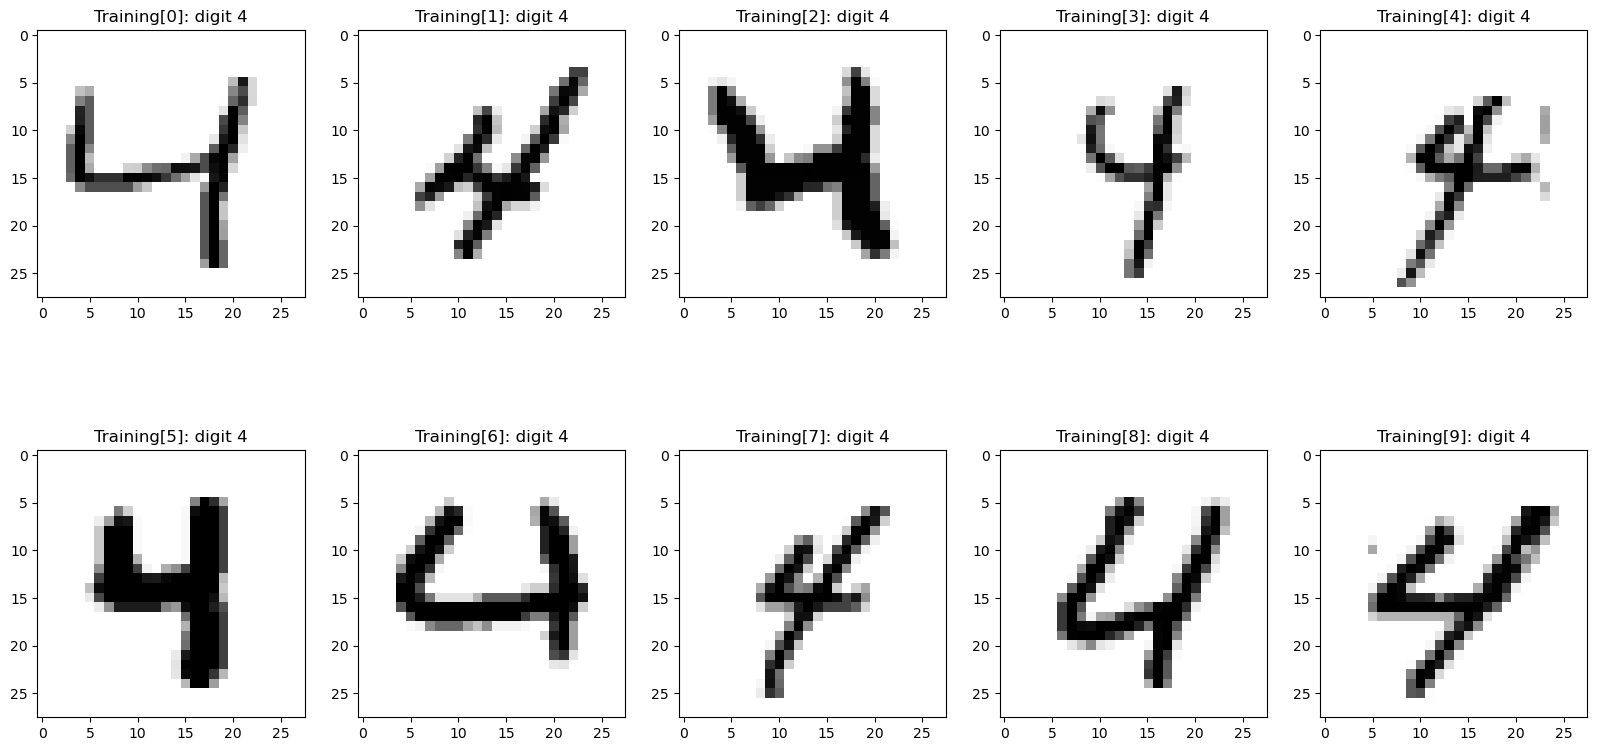

In [22]:
plt.figure(1, figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train2[i,:,:], cmap=plt.cm.gray_r)
    plt.title('Training[' + str(i) + ']: digit ' + str(int(y_train2[i])))

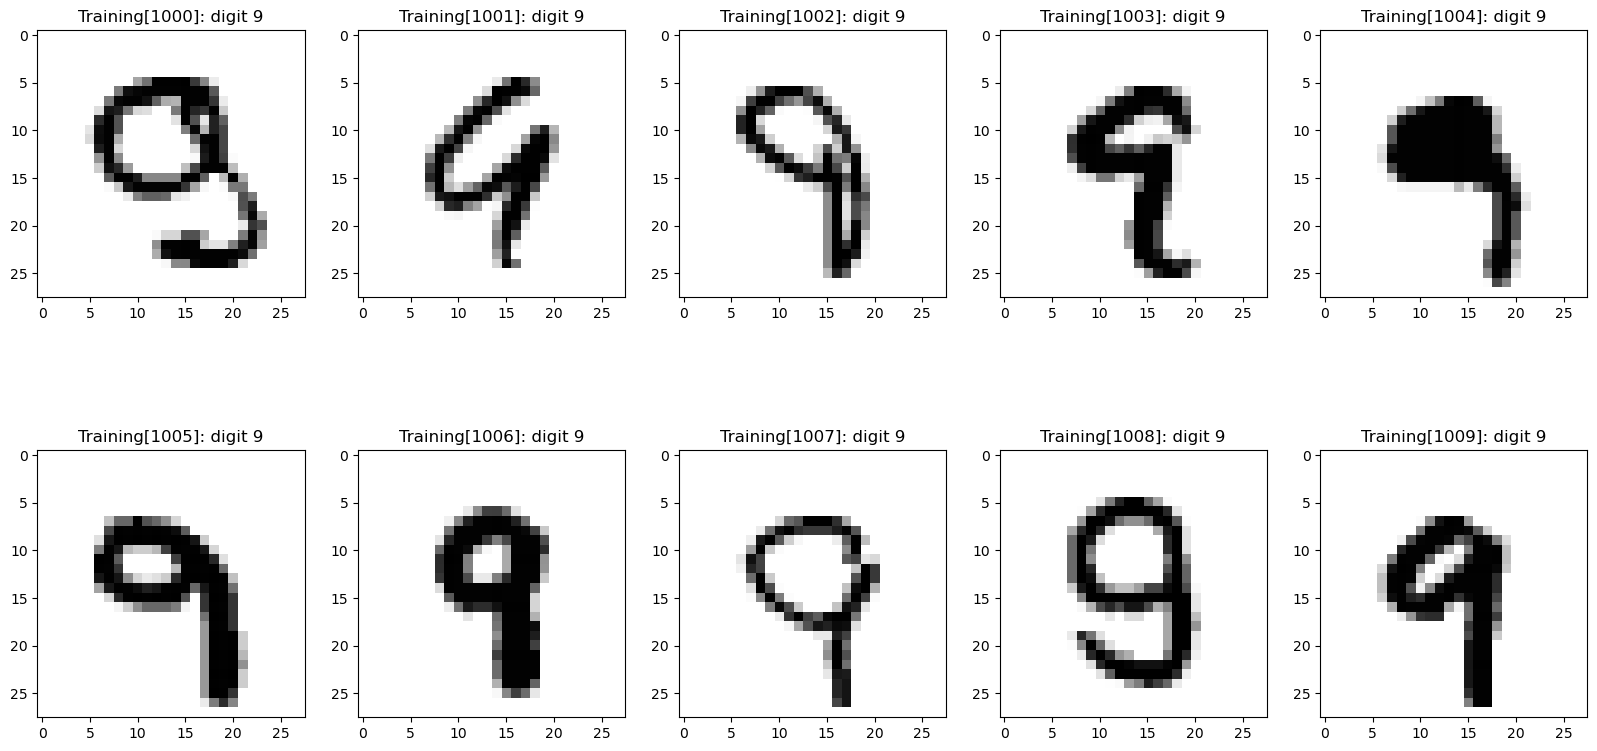

In [23]:
plt.figure(1, figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test2[i + 1000,:,:], cmap=plt.cm.gray_r)
    plt.title('Training[' + str(i + 1000) + ']: digit ' + str(int(y_test2[i + 1000])))

Format the labels

In [24]:
y_train2_d = np.transpose(np.stack((np.round((9 - y_train2) / 5).astype(int), np.round((y_train2 - 4) / 5).astype(int)), axis = 0))
print(y_train2_d.shape)
y_test2_d = np.transpose(np.stack((np.round((9 - y_test2) / 5).astype(int), np.round((y_test2 - 4) / 5).astype(int)), axis = 0))
print(y_test2_d.shape)

(200, 2)
(1991, 2)


Train the NN

In [25]:
class DNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [26]:
net2 = DNN2()
criterion = nn.MSELoss()
net2.to(device)
optimizer = optim.Adam(net2.parameters(), lr = 0.01)
miniBatchSize = 1
epochSize = x_train2.shape[0]
print(net2)

DNN2(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
)


In [27]:
tensor_x = torch.Tensor(x_train2)
tensor_y = torch.Tensor(y_train2_d)
my_dataset = TensorDataset(tensor_x, tensor_y)
my_dataloader = DataLoader(my_dataset, batch_size=miniBatchSize, shuffle=True)
for iEpoch in range(15):
    print("Epoch " + str(iEpoch + 1))
    running_loss = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(my_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Print current statistics
        batch_loss = loss.item()
        running_loss += batch_loss
        epoch_loss += batch_loss
        if i % 50 == 49: # print every 50 mini-batches
            print('[%d, %5d] loss: %.6f (%.8f)' % (iEpoch + 1, i + 1, running_loss / 50, epoch_loss / (i + 1)))
            running_loss = 0.0
    print("Epoch loss = " + str(epoch_loss / (epochSize / miniBatchSize)))

Epoch 1
[1,    50] loss: 0.250364 (0.25036420)
[1,   100] loss: 0.189069 (0.21971639)
[1,   150] loss: 0.137200 (0.19221104)
[1,   200] loss: 0.104004 (0.17015932)
Epoch loss = 0.17015932434238493
Epoch 2
[2,    50] loss: 0.044702 (0.04470171)
[2,   100] loss: 0.022307 (0.03350425)
[2,   150] loss: 0.026080 (0.03102960)
[2,   200] loss: 0.065440 (0.03963232)
Epoch loss = 0.039632320555392654
Epoch 3
[3,    50] loss: 0.006617 (0.00661670)
[3,   100] loss: 0.004672 (0.00564458)
[3,   150] loss: 0.055854 (0.02238121)
[3,   200] loss: 0.005673 (0.01820407)
Epoch loss = 0.018204074000241235
Epoch 4
[4,    50] loss: 0.018208 (0.01820808)
[4,   100] loss: 0.003656 (0.01093217)
[4,   150] loss: 0.055306 (0.02572342)
[4,   200] loss: 0.002431 (0.01990028)
Epoch loss = 0.019900282661546954
Epoch 5
[5,    50] loss: 0.020412 (0.02041233)
[5,   100] loss: 0.017547 (0.01897945)
[5,   150] loss: 0.038521 (0.02549327)
[5,   200] loss: 0.030222 (0.02667545)
Epoch loss = 0.026675450588809328
Epoch 6
[6,

Test the performance of the network on the test set

In [28]:
net2_output = np.empty((x_test2.shape[0]))
tensor_x = torch.Tensor(x_test2)
my_dataset = TensorDataset(tensor_x)
my_dataloader = DataLoader(my_dataset, batch_size = x_test2.shape[0], shuffle = False)
with torch.no_grad():
    for i, data in enumerate(my_dataloader, 0):
        curInput = data[0].to(device)
        net2_output = np.array((net2(curInput).numpy(force = True)[:,1] > 0.5) * 5 + 4, dtype = int)
print(net2_output.shape)
print(net2_output[:10])
print(net2_output[1500:1510])
print('Error on the test sample equals %.2f%% or %d observations.' % 
      (np.mean(net2_output != y_test2) * 100, np.sum(net2_output != y_test2)))

(1991,)
[4 4 4 4 4 4 4 4 4 4]
[9 9 4 9 9 4 9 9 9 9]
Error on the test sample equals 7.89% or 157 observations.


## 1.e Comparison with LDA

In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [30]:
lda1 = LDA()
lda1.fit(x_train1_flat, y_train1)
forecastLDA1 = lda1.predict(x_test1_flat)
print(forecastLDA1.shape)
print(y_test1.shape)
print('Accuracy of LDA on test data 1: ' + str(np.mean(forecastLDA1 == y_test1)))

(2000,)
(2000,)
Accuracy of LDA on test data 1: 0.99


In [31]:
lda2 = LDA()
lda2.fit(x_train2.reshape(x_train2.shape[0], 28 * 28), y_train2)
forecastLDA2 = lda2.predict(x_test2.reshape(x_test2.shape[0], 28 * 28))
print(forecastLDA2.shape)
print(y_test2.shape)
print('Accuracy of LDA on test data 2: ' + str(np.mean(forecastLDA2 == y_test2)))

(1991,)
(1991,)
Accuracy of LDA on test data 2: 0.8970366649924661


# 2. Convolutional neural network

## 2.a Prepare the data

Train data for now

In [32]:
x_train3 = x_train[:1000,:,:]
print(x_train3.shape)
x_train3_deep = x_train3.reshape((x_train3.shape[0], 1, x_train3.shape[1], x_train3.shape[2]))
print(x_train3_deep.shape)
y_train3 = y_train[:1000]
print(y_train3[:100])
print(y_train3.shape)
y_train3_onehot = np.zeros((y_train3.shape[0], int(y_train3.max()) + 1), dtype = int)
y_train3_onehot[np.arange(y_train3.size),y_train3] = 1 
print(y_train3_onehot.shape)
print(y_train3_onehot[:15,:])

(1000, 28, 28)
(1000, 1, 28, 28)
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 9 3 3 0 7 4 9 8 0 9 4 1 4 4 6 0 4 5 6 1 0 0 1 7 1 6
 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1]
(1000,)
(1000, 10)
[[0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]]


## 2.b Train the LeCun convolutional neural network

Define the network

In [33]:
# Input: 224x224

class CNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 4, 5)
        self.pool0 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(4, 12, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(12 * 4 * 4, 10)

    def forward(self, x):
        x = self.pool0(F.relu(self.conv0(x)))
        x = self.pool1(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.sigmoid(self.fc1(x))
        return x

Set the parameters

In [34]:
net3 = CNN3()
criterion = nn.CrossEntropyLoss()
net3.to(device)
optimizer = optim.Adam(net3.parameters(), lr = 0.001)
miniBatchSize = 1
epochSize = x_train3.shape[0]
print(net3)

CNN3(
  (conv0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=192, out_features=10, bias=True)
)


Start the training process

In [35]:
tensor_x = torch.Tensor(x_train3_deep)
tensor_y = torch.Tensor(y_train3_onehot)
my_dataset = TensorDataset(tensor_x, tensor_y)
my_dataloader = DataLoader(my_dataset, batch_size=miniBatchSize, shuffle=True)
for iEpoch in range(10):
    print("Epoch " + str(iEpoch + 1))
    running_loss = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(my_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Print current statistics
        batch_loss = loss.item()
        running_loss += batch_loss
        epoch_loss += batch_loss
        if i % 50 == 49: # print every 50 mini-batches
            print('[%d, %5d] loss: %.6f (%.8f)' % (iEpoch + 1, i + 1, running_loss / 50, epoch_loss / (i + 1)))
            running_loss = 0.0
    print("Epoch loss = " + str(epoch_loss / (epochSize / miniBatchSize)))

Epoch 1
[1,    50] loss: 2.307982 (2.30798225)
[1,   100] loss: 2.281653 (2.29481743)
[1,   150] loss: 2.241241 (2.27695849)
[1,   200] loss: 2.223094 (2.26349245)
[1,   250] loss: 2.127459 (2.23628570)
[1,   300] loss: 2.045851 (2.20454664)
[1,   350] loss: 1.957645 (2.16927503)
[1,   400] loss: 1.805280 (2.12377562)
[1,   450] loss: 1.795258 (2.08727361)
[1,   500] loss: 1.793082 (2.05785445)
[1,   550] loss: 1.765160 (2.03124591)
[1,   600] loss: 1.681593 (2.00210817)
[1,   650] loss: 1.652687 (1.97522964)
[1,   700] loss: 1.625885 (1.95027643)
[1,   750] loss: 1.562078 (1.92439656)
[1,   800] loss: 1.704598 (1.91065916)
[1,   850] loss: 1.622946 (1.89373483)
[1,   900] loss: 1.612178 (1.87809280)
[1,   950] loss: 1.652474 (1.86621815)
[1,  1000] loss: 1.591251 (1.85246978)
Epoch loss = 1.8524697806835175
Epoch 2
[2,    50] loss: 1.615094 (1.61509432)
[2,   100] loss: 1.650238 (1.63266593)
[2,   150] loss: 1.636631 (1.63398761)
[2,   200] loss: 1.606385 (1.62708687)
[2,   250] loss:

## 2.c Test the accuracy of the trained convolutional neural network

Prepare the test data

In [36]:
x_test3 = x_test
print(x_test3.shape)
x_test3_deep = x_test3.reshape((x_test3.shape[0], 1, x_test3.shape[1], x_test3.shape[2]))
print(x_test3_deep.shape)
y_test3 = y_test
print(y_test3.shape)

(10000, 28, 28)
(10000, 1, 28, 28)
(10000,)


Run the test

In [37]:
net3_output = np.empty((x_test3.shape[0], 10))
tensor_x = torch.Tensor(x_test3_deep)
my_dataset = TensorDataset(tensor_x)
my_dataloader = DataLoader(my_dataset, batch_size = x_test3_deep.shape[0], shuffle = False)
with torch.no_grad():
    for i, data in enumerate(my_dataloader, 0):
        curInput = data[0].to(device)
        net3_output = np.array((net3(curInput).numpy(force = True)))
print(net3_output.shape)
net3_output_one = np.argmax(net3_output, axis = 1)
print('Error on the test sample equals %.2f%% or %d observations.' % 
      (np.mean(net3_output_one != y_test3) * 100, np.sum(net3_output_one != y_test3)))

(10000, 10)
Error on the test sample equals 6.46% or 646 observations.
